<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

In [15]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import os,sys
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import SimpleITK as sitk
from scipy import ndimage as ndi
import skimage as skim
from skimage import feature
import pandas as pd
import xarray as xr
plt.rcParams['figure.figsize'] = (10,8)
import pickle as pkl
from mre import pytorch_unet_tb
from mre.prediction import MREDataset
from mre.plotting import torch_dl_vis
from tensorboardX import SummaryWriter
from torch.utils.data import Dataset, DataLoader
import torchvision.utils
from torchsummary import summary
import torch
import torch.nn as nn
from collections import defaultdict
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
import time
import copy
import mre.prediction as pred


# Load mre data
full_data_dir = '/pghbio/dbmi/batmanlab/Data/MRE/'
ds = pkl.load(open(full_data_dir+'mre_ds_preprocess_3.p', 'rb'))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
ds

<xarray.Dataset>
Dimensions:      (sequence: 10, subject: 48, x: 256, y: 256, z: 4)
Coordinates:
  * subject      (subject) <U3 '162' '163' '178' '189' ... '404' '405' '406'
  * sequence     (sequence) <U8 'T1Pre' 'T1Pos' 'T2FR' ... 'extra2' 'extra3'
Dimensions without coordinates: x, y, z
Data variables:
    image        (subject, sequence, z, y, x) float32 0.0 0.0 0.0 ... 0.0 0.0
    age          (subject) int8 -27 -91 -107 117 -123 ... -107 -107 5 -59 101
    z_space      (subject, sequence) float16 13.8 10.0 10.0 10.0 ... 0.0 0.0 0.0
    z_space_std  (subject) float16 1.684 3.826 6.656 1.6 ... 3.812 1.049 2.854

In [6]:
print(ds.sequence)
print(ds.subject[0])

<xarray.DataArray 'sequence' (sequence: 10)>
array(['T1Pre', 'T1Pos', 'T2FR', 'T2SS', 'elastMsk', 'elast', 'msk',
       'liverMsk', 'extra2', 'extra3'], dtype='<U8')
Coordinates:
  * sequence  (sequence) <U8 'T1Pre' 'T1Pos' 'T2FR' ... 'extra2' 'extra3'
<xarray.DataArray 'subject' ()>
array('162', dtype='<U3')
Coordinates:
    subject  <U3 '162'


In [15]:
# Use xArray to define the dataset.  Easy to query and map (although might not be fast when scaling up)
# input_example = ds.sel(sequence=['T2SS', 'T1Pre', 'T1Pos', 'T2FR']).image
input_example = ds.sel(sequence=['T2SS', 'T1Pre', 'T1Pos']).image
target_example = ds.sel(sequence=['elast']).image

In [16]:
input_example.values.shape

(48, 3, 4, 256, 256)

In [7]:
trans=False
clip=False

train_set = MREDataset(ds, set_type='train', transform = trans, clip=clip)
val_set = MREDataset(ds, set_type='val', transform = trans, clip=clip)
test_set = MREDataset(ds, set_type='test', transform = trans, clip=clip)

image_datasets = {
    'train': train_set, 'val': val_set, 'test':test_set
}

batch_size = 10

dataloaders = {
    'train': DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=0),
    'val': DataLoader(val_set, batch_size=batch_size, shuffle=True, num_workers=0),
    'test': DataLoader(test_set, batch_size=batch_size, shuffle=True, num_workers=0)
}

dataset_sizes = {
    x: len(image_datasets[x]) for x in image_datasets.keys()
}

dataset_sizes

{'train': 172, 'val': 18, 'test': 2}

torch.Size([2, 3, 256, 256])
torch.Size([2, 1, 256, 256])
lol


/home/bpollack/conda_envs/new_mre/lib/python3.6/site-packages/matplotlib/figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


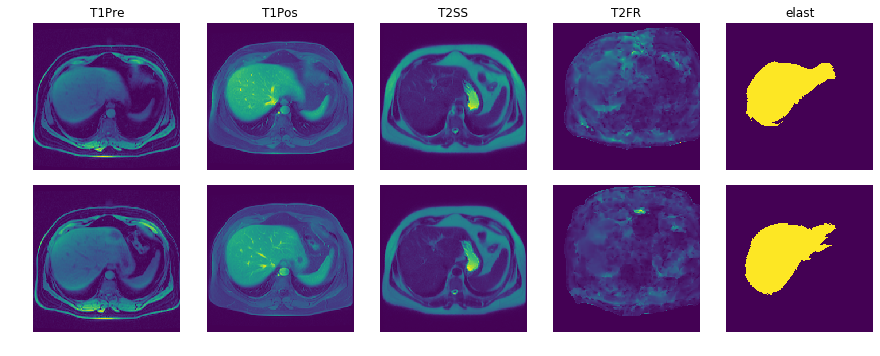

In [27]:
# Get a batch of training data
inputs, targets, masks= next(iter(dataloaders['test']))

#print(inputs.shape, masks.shape)
#for x in [inputs.numpy(), masks.numpy()]:
#    print(x.min(), x.max(), x.mean(), x.std())
print(inputs.shape)
print(targets.shape)

torch_dl_vis(inputs, targets, masks)

In [13]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

model = pytorch_unet_tb.UNet(1)
model = model.to(device)

summary(model, input_size=(3, 256, 256))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 256, 256]           1,792
       BatchNorm2d-2         [-1, 64, 256, 256]             128
              ReLU-3         [-1, 64, 256, 256]               0
            Conv2d-4         [-1, 64, 256, 256]          36,928
       BatchNorm2d-5         [-1, 64, 256, 256]             128
              ReLU-6         [-1, 64, 256, 256]               0
         MaxPool2d-7         [-1, 64, 128, 128]               0
            Conv2d-8         [-1, 64, 128, 128]          36,928
       BatchNorm2d-9         [-1, 64, 128, 128]             128
             ReLU-10         [-1, 64, 128, 128]               0
           Conv2d-11         [-1, 64, 128, 128]          36,928
      BatchNorm2d-12         [-1, 64, 128, 128]             128
             ReLU-13         [-1, 64, 128, 128]               0
        MaxPool2d-14           [-1

In [17]:
from datetime import datetime

datetime.today().strftime('%Y-%m-%d_%H-%M-%S')

'2019-05-01_17-37-58'

In [20]:
from datetime import datetime
now = datetime.today().strftime('%Y-%m-%d_%H-%M-%S')

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

num_class = 1

model = pytorch_unet_tb.UNet(num_class).to(device)

# Observe that all parameters are being optimized
optimizer_ft = optim.Adam(model.parameters(), lr=5e-3)

exp_lr_scheduler = pred.lr_scheduler.StepLR(optimizer_ft, step_size=25, gamma=0.1)

#writer = SummaryWriter('runs/baseline')
#writer = SummaryWriter('runs/clip_0')
#writer = SummaryWriter('runs/clip_norm_0')
#writer = SummaryWriter('runs/norm_redcap_0')
writer = SummaryWriter('runs/'+now)
model = pred.train_model(model, optimizer_ft, exp_lr_scheduler, device, dataloaders, num_epochs=40, tb_writer=writer)
#writer.export_scalars_to_json("./all_scalars.json")
writer.close()




cuda:0
Epoch 0/39
----------
LR 0.005
train: loss: 20588196.255814
val: loss: 13705576.888889
saving best model
0m 2s
Epoch 1/39
----------
LR 0.005
train: loss: 20399822.627907
val: loss: 13742319.222222
0m 2s
Epoch 2/39
----------
LR 0.005
train: loss: 20177781.058140
val: loss: 13409708.555556
saving best model
0m 2s
Epoch 3/39
----------
LR 0.005
train: loss: 20282923.267442
val: loss: 13662783.888889
0m 2s
Epoch 4/39
----------
LR 0.005
train: loss: 20063010.581395
val: loss: 13444666.888889
0m 2s
Epoch 5/39
----------
LR 0.005
train: loss: 19756286.046512
val: loss: 13240750.777778
saving best model
0m 2s
Epoch 6/39
----------
LR 0.005
train: loss: 19315386.924419
val: loss: 12850751.222222
saving best model
0m 2s
Epoch 7/39
----------
LR 0.005
train: loss: 19119643.348837
val: loss: 12337393.000000
saving best model
0m 2s
Epoch 8/39
----------
LR 0.005
train: loss: 18844647.430233
val: loss: 12957306.000000
0m 2s
Epoch 9/39
----------
LR 0.005
train: loss: 18356317.348837
val: l

In [25]:
# prediction

import math

model.eval()   # Set model to evaluate mode

test_loader =  DataLoader(test_set, batch_size=1, shuffle=True, num_workers=0)
#test_loader = DataLoader(test_dataset, batch_size=3, shuffle=False, num_workers=0)
        
inputs, labels, masks = next(iter(test_loader))
inputs = inputs.to(device)
labels = labels.to(device)

pred = model(inputs)

pred = pred.data.cpu().numpy()
labels = labels.data.cpu().numpy()
inputs = inputs.data.cpu().numpy()
masks = masks.data.cpu().numpy()
print(inputs.shape)

# Change channel-order and make 3 channels for matplot
#input_images_rgb = [reverse_transform(x) for x in inputs.cpu()]

# Map each channel (i.e. class) to each color
#target_masks_rgb = [helper.masks_to_colorimg(x) for x in labels.cpu().numpy()]
#pred_rgb = [helper.masks_to_colorimg(x) for x in pred]

#helper.plot_side_by_side([input_images_rgb, target_masks_rgb, pred_rgb])

(1, 3, 256, 256)


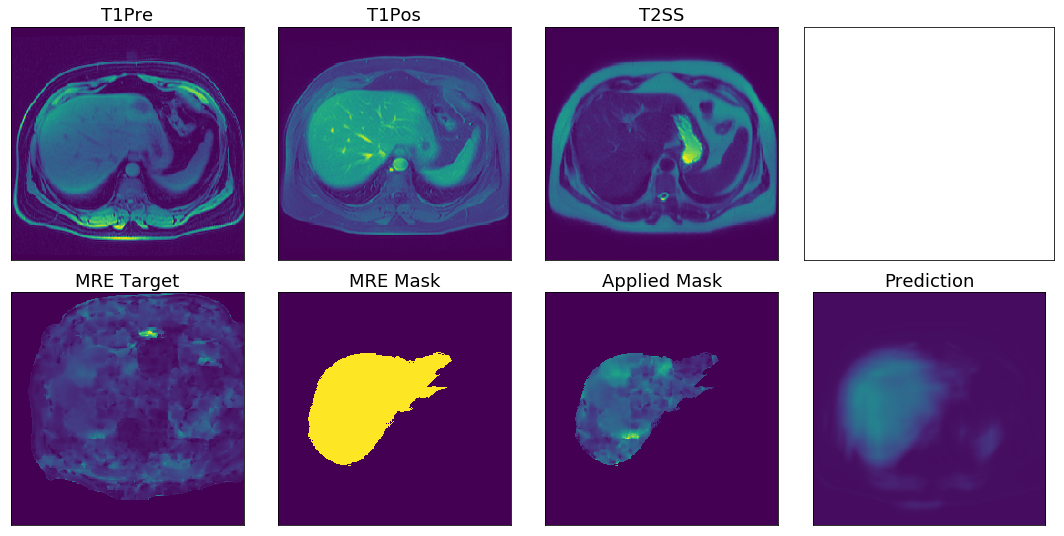

In [26]:
fig, axs = plt.subplots(2, 4, figsize=(3.75*4, 3.75*2),
                             sharex=True, sharey=True,)
axs[0][0].imshow(inputs[0][0])
axs[0][0].set_title('T1Pre', size=18)

axs[0][1].imshow(inputs[0][1])
axs[0][1].set_title('T1Pos', size=18)
axs[0][2].imshow(inputs[0][2])
axs[0][2].set_title('T2SS', size=18)
#axs[0][3].imshow(inputs[0][3])
#axs[0][3].set_title('T2FR', size=18)
target = labels[0][0]
mask = masks[0][0]
prediction = pred[0][0]
target_mask = target*mask
prediction_mask = prediction*mask

axs[1][0].imshow(target)
axs[1][0].set_title('MRE Target', size=18)
axs[1][1].imshow(mask)
axs[1][1].set_title('MRE Mask', size=18)
axs[1][2].imshow(target_mask, vmin=target_mask.min(), vmax=target_mask.max())
axs[1][2].set_title('Applied Mask', size=18)
axs[1][3].imshow(prediction, vmin=target_mask.min(), vmax=target_mask.max())
axs[1][3].set_title('Prediction', size=18)

plt.xticks([])
plt.yticks([])

fig.tight_layout()
#plt.savefig('../plots/prediction.png')
#plt.savefig('../plots/prediction.pdf')

In [23]:
np.sum((labels[0][0]*masks[0][0]-pred[0][0]*masks[0][0])**2)/np.sum(masks[0][0])

1563360.8